In [1]:
import pandas as pd
pd.set_option('display.max_columns',50)
import numpy as np
import itertools as it
import json

import geopandas as gpd
import urllib.request

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

from scipy.stats import entropy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

In [2]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()


all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

regions_dict = {'Plains':['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
 'Rocky Mountains':['CO', 'ID', 'MT', 'UT', 'WY'],
 'Far West':['AK', 'CA', 'HI', 'NV', 'OR', 'WA'],
 'Southwest':['AZ', 'NM', 'OK', 'TX'],
 'Great Lakes':['IL', 'IN', 'MI', 'OH', 'WI'],
 'Southeast':['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV'],
 'Other U.S. jurisdictions':['AS', 'GU', 'MP', 'PR', 'VI'],
 'New England':['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
 'Mid East':['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']}
regions_dict_id = {i:[all_ids_state[x.lower()] for x in j] for i,j in regions_dict.items()}

reg_names = [[list(regions_dict_id.keys())[i]]*len(list(regions_dict_id.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict_id.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,'state':[all_state_names[all_state_ids[i]] for i in flat_state]})

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))

In [3]:
# https://www.nytimes.com/interactive/2021/us/college-covid-tracker.html
url_nyt = 'https://static01.nyt.com/newsgraphics/2021/02/18/college-virus-tracker-21/'+\
          'd9657aa176d48a60a64c5c6b267311c222032f5f/collegedata.json'

In [4]:
with urllib.request.urlopen(url_nyt) as url_i:
    curr_nyt_data = json.loads(url_i.read().decode())

# with open('../data/collegedata.json') as f:
#     curr_nyt_data = json.load(f)

nyt_data = pd.DataFrame(curr_nyt_data)
curr_nyt_data = pd.DataFrame(curr_nyt_data)
curr_nyt_data.loc[curr_nyt_data['ipeds_id']=='laccd','ipeds_id'] = '117681'

In [5]:
prev_nyt_data = pd.read_csv('../data/nyt_data_asof_2021-04-30.csv', dtype={'ipeds_id':str,'fips':str})

In [6]:
curr_nyt_data.loc[~curr_nyt_data['ipeds_id'].isin(prev_nyt_data['ipeds_id'].unique())]

,ipeds_id,nytname,infected_2021,infected_2020,all_cases,shortname,size,lat,long,county,state,geoid,growth_rate,total_all,med,dag2,dag1


In [7]:
# missing_df_to_add = prev_nyt_data.loc[prev_nyt_data['ipeds_id']==prev_nyt_data['ipeds_id'].min()].copy()
# missing_df_to_add['ipeds_id'] = '228158'
# missing_df_to_add['state'] = 'Texas'
# missing_df_to_add['county'] = 'Hockley'
# missing_df_to_add['city'] = 'Levelland'
# missing_df_to_add['college'] = 'South Plains College'
# missing_df_to_add['cases'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
# missing_df_to_add['new_cases'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
# missing_df_to_add['fips'] = '48219'
# missing_df_to_add

In [8]:
# prev_nyt_data = pd.concat([prev_nyt_data, missing_df_to_add])

In [9]:
prev_nyt_data.head(5)

,date,end_date,start_date,period,ipeds_id,state,county,city,college,cases,new_cases,fips,infected_2020,infected_2021,region,region_label
0,2020-10-08,2020-10-08,2020-09-25,0,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,NaN,01089,41.0,NaN,Southeast,Southeast (n=569)
1,2020-10-22,2020-10-22,2020-10-09,1,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089,41.0,NaN,Southeast,Southeast (n=569)
2,2020-11-05,2020-11-05,2020-10-23,2,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089,41.0,NaN,Southeast,Southeast (n=569)
3,2020-11-19,2020-11-19,2020-11-06,3,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089,41.0,NaN,Southeast,Southeast (n=569)
4,2020-12-11,2020-12-11,2020-11-20,4,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089,41.0,NaN,Southeast,Southeast (n=569)


In [10]:
print(curr_nyt_data.shape)
curr_nyt_data.head()

(1949, 17)


,ipeds_id,nytname,infected_2021,infected_2020,all_cases,shortname,size,lat,long,county,state,geoid,growth_rate,total_all,med,dag2,dag1
0,151351,Indiana University Bloomington,1607,6871,,Indiana,l,39.1754487,-86.512627,Monroe,Ind.,USA-18105,23,8478,NaN,NaN,NaN
1,134130,University of Florida,3040,6756,,Florida,l,29.6436325,-82.35493,Alachua,Fla.,USA-12001,45,9796,y,NaN,NaN
2,228723,Texas A&M University,2790,2767,,Texas A&M,l,30.6187558,-96.336477,Brazos,Texas,USA-48041,101,5557,NaN,NaN,NaN
3,170976,University of Michigan,2783,3243,,Michigan,l,42.2780436,-83.738224,Washtenaw,Mich.,USA-26161,86,6026,NaN,NaN,NaN
4,214777,Penn State University,2535,5006,,Penn State,l,40.7982133,-77.859908,Centre,Pa.,USA-42027,51,7541,NaN,NaN,NaN


In [11]:
curr_nyt_data['date'] = '2021-05-30'
curr_nyt_data['end_date'] = '2021-05-26'
curr_nyt_data['start_date'] = '2021-05-01'
curr_nyt_data['period'] = prev_nyt_data['period'].max()+1
# curr_nyt_data['date'] = '2021-02-24'
# curr_nyt_data['end_date'] = '2021-02-24'
# curr_nyt_data['start_date'] = '2021-01-01'
# curr_nyt_data['period'] = prev_nyt_data['period'].max()+1

In [12]:
curr_nyt_data = curr_nyt_data.merge(prev_nyt_data[['ipeds_id','fips']].drop_duplicates(),
                                    how='left', on='ipeds_id')

In [13]:
map_projection_init = "epsg:4269"
map_projection = "epsg:2163"

drop_list = ["72","78","69","66","60","02","15"]

gdfcounty = gpd.read_file('../../covid19-mobility/data/tl_2017_us_county/')
gdfstate = gpd.read_file('../../covid19-mobility/data/tl_2017_us_state/')

gdfs = gdfstate.loc[~gdfstate['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfc = gdfcounty.loc[~gdfcounty['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfs_AL = gdfstate.loc[gdfstate['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfc_AL = gdfcounty.loc[gdfcounty['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfs_HI = gdfstate.loc[gdfstate['STATEFP']=='15'].copy().reset_index().iloc[:,1:]
gdfc_HI = gdfcounty.loc[gdfcounty['STATEFP']=='15'].copy().reset_index().iloc[:,1:]

gdfs.crs = {"init": map_projection_init}
gdfc.crs = {"init": map_projection_init}
gdfs_AL.crs = {"init": map_projection_init}
gdfc_AL.crs = {"init": map_projection_init}
gdfs_HI.crs = {"init": map_projection_init}
gdfc_HI.crs = {"init": map_projection_init}

gdfs = gdfs.to_crs({"init": map_projection})
gdfc = gdfc.to_crs({"init": map_projection})
gdfs_AL = gdfs_AL.to_crs({"init": map_projection})
gdfc_AL = gdfc_AL.to_crs({"init": map_projection})
gdfs_HI = gdfs_HI.to_crs({"init": map_projection})
gdfc_HI = gdfc_HI.to_crs({"init": map_projection})

In [16]:
tmp = curr_nyt_data.rename(columns={'total_all':'cases'})[['date', 'end_date', 'start_date',
                                                           'period', 'ipeds_id','cases']]
tmp['new_cases'] = np.nan
prev_cases = prev_nyt_data.loc[prev_nyt_data['period']==prev_nyt_data['period'].max()][['ipeds_id','cases']].copy()
prev_cases = prev_cases.rename(columns={'cases':'prev_cases'})
tmp.loc[tmp['cases']=='tbd','cases'] = np.nan
tmp.loc[tmp['cases']=='','cases'] = np.nan
tmp['cases'] = tmp['cases'].astype(float)

tmp = tmp.merge(prev_cases, how='left', on='ipeds_id')
tmp['new_cases'] = tmp['cases'] - tmp['prev_cases']

tmp = tmp.merge(prev_nyt_data[['ipeds_id','state','county','city','college','fips']].drop_duplicates(),
                how='left', on='ipeds_id')

In [17]:
nyt_df = pd.concat([prev_nyt_data[[i for i in prev_nyt_data.columns if i in tmp.columns]],
                    tmp[[i for i in prev_nyt_data.columns if i in tmp.columns]]])
nyt_df = nyt_df.sort_values(['ipeds_id','date']).reset_index().iloc[:,1:]
nyt_df

,date,end_date,start_date,period,ipeds_id,state,county,city,college,cases,new_cases,fips
0,2020-10-08,2020-10-08,2020-09-25,0,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,NaN,01089
1,2020-10-22,2020-10-22,2020-10-09,1,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089
2,2020-11-05,2020-11-05,2020-10-23,2,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089
3,2020-11-19,2020-11-19,2020-11-06,3,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089
4,2020-12-11,2020-12-11,2020-11-20,4,100654,Alabama,Madison,Huntsville,Alabama A&M University,41.0,0.0,01089
...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2020-11-19,2020-11-19,2020-11-06,3,494551,New York,New York,New York City,Glasgow Caledonian New York College,0.0,NaN,36061
15630,2020-12-11,2020-12-11,2020-11-20,4,494551,New York,New York,New York City,Glasgow Caledonian New York College,0.0,0.0,36061
15631,2021-02-24,2021-02-24,2021-01-01,5,494551,New York,New York,New York City,Glasgow Caledonian New York College,1.0,1.0,36061
15632,2021-04-30,2021-04-30,2021-02-25,6,494551,New York,New York,New York City,Glasgow Caledonian New York College,1.0,0.0,36061


In [18]:
nyt_df = nyt_df.merge(curr_nyt_data[['ipeds_id', 'infected_2020', 'infected_2021']],how='left',on='ipeds_id')
nyt_df.loc[nyt_df['cases']=='tbd','cases'] = np.nan
nyt_df.loc[nyt_df['cases']=='','cases'] = np.nan
nyt_df.loc[nyt_df['infected_2020']=='','infected_2020'] = np.nan
nyt_df.loc[nyt_df['infected_2021']=='','infected_2021'] = np.nan
nyt_df['cases'] = nyt_df['cases'].astype(float)
nyt_df['infected_2020'] = nyt_df['infected_2020'].astype(float)
nyt_df['infected_2021'] = nyt_df['infected_2021'].astype(float)
nyt_df.loc[nyt_df['cases']<0,'cases'] = 0.0
nyt_df = nyt_df.merge(region_df, how='left', on='state')

In [19]:

region_summary = nyt_df[['ipeds_id','region']].drop_duplicates().groupby('region').agg({'ipeds_id':'count'}).reset_index()
region_summary_dict = dict(zip(region_summary['region'].values, region_summary['ipeds_id'].values))
nyt_df['region_label'] = [i+" (n=%i)"%(region_summary_dict[i]) if not pd.isna(i) else 'nan' for i in nyt_df['region'].values]

tmpx = nyt_df.groupby('ipeds_id').agg({'period':'max'}).reset_index()

missing_new_df = nyt_df.loc[nyt_df['ipeds_id'].isin(tmpx.loc[tmpx['period']<5]['ipeds_id'].values)].copy()
nyt_df = nyt_df.loc[~nyt_df['ipeds_id'].isin(missing_new_df['ipeds_id'].unique())].copy()
missing_new_df_add = missing_new_df.loc[missing_new_df['period']==missing_new_df['period'].max()].copy()
missing_new_df_add['period'] = nyt_df['period'].max()
missing_new_df_add['date'] = nyt_df['date'].max()
missing_new_df_add['end_date'] = nyt_df['end_date'].max()
missing_new_df_add['start_date'] = nyt_df['start_date'].max()
missing_add_df = pd.concat([missing_new_df, missing_new_df_add]).sort_values(['ipeds_id','period'])
nyt_df = pd.concat([nyt_df, missing_add_df]).sort_values(['ipeds_id','period'])

In [20]:
curr_nyt_data['long'] = curr_nyt_data['long'].astype(float)
curr_nyt_data['lat'] = curr_nyt_data['lat'].astype(float)
curr_nyt_data['ipeds_id'] = curr_nyt_data['ipeds_id'].astype(str)

In [21]:
nyt_df_geo = nyt_df.merge(curr_nyt_data[['ipeds_id','long','lat']].drop_duplicates(), how='left', on='ipeds_id')
nyt_df_geo = nyt_df_geo.loc[nyt_df_geo['region_label']!='nan'].copy()

In [22]:
drop_long = ['American Samoa','Guam','Northern Mariana Islands','Puerto Rico','Virgin Islands','Marshall Islands']
nyt_gdf = gpd.GeoDataFrame(nyt_df_geo, geometry=gpd.points_from_xy(nyt_df_geo.long, nyt_df_geo.lat))
nyt_gdf = nyt_gdf.loc[~nyt_gdf['state'].isin(drop_long)].copy().reset_index().iloc[:,1:]

nyt_gdf.crs = {"init": map_projection_init}
nyt_gdf = nyt_gdf.to_crs({"init": map_projection})

nyt_gdf_AL = nyt_gdf.loc[nyt_gdf['state']=='Alaska'].copy()
nyt_gdf_HI = nyt_gdf.loc[nyt_gdf['state']=='Hawaii'].copy()
nyt_gdf = nyt_gdf.loc[~nyt_gdf['state'].isin(['Alaska','Hawaii'])].copy()

In [23]:
hi_centroid = gdfs_HI['geometry'].centroid
al_centroid = gdfs_AL['geometry'].centroid
al_rotate = 24
hi_rotate = 24
gdfs_HI['geometry'] = gdfs_HI.rotate(hi_rotate, origin=hi_centroid[0])
gdfs_AL['geometry'] = gdfs_AL.rotate(al_rotate, origin=al_centroid[0])
gdfc_HI['geometry'] = gdfc_HI.rotate(hi_rotate, origin=hi_centroid[0])
gdfc_AL['geometry'] = gdfc_AL.rotate(al_rotate, origin=al_centroid[0])
nyt_gdf_HI['geometry'] = nyt_gdf_HI.rotate(hi_rotate, origin=hi_centroid[0])
nyt_gdf_AL['geometry'] = nyt_gdf_AL.rotate(al_rotate, origin=al_centroid[0])

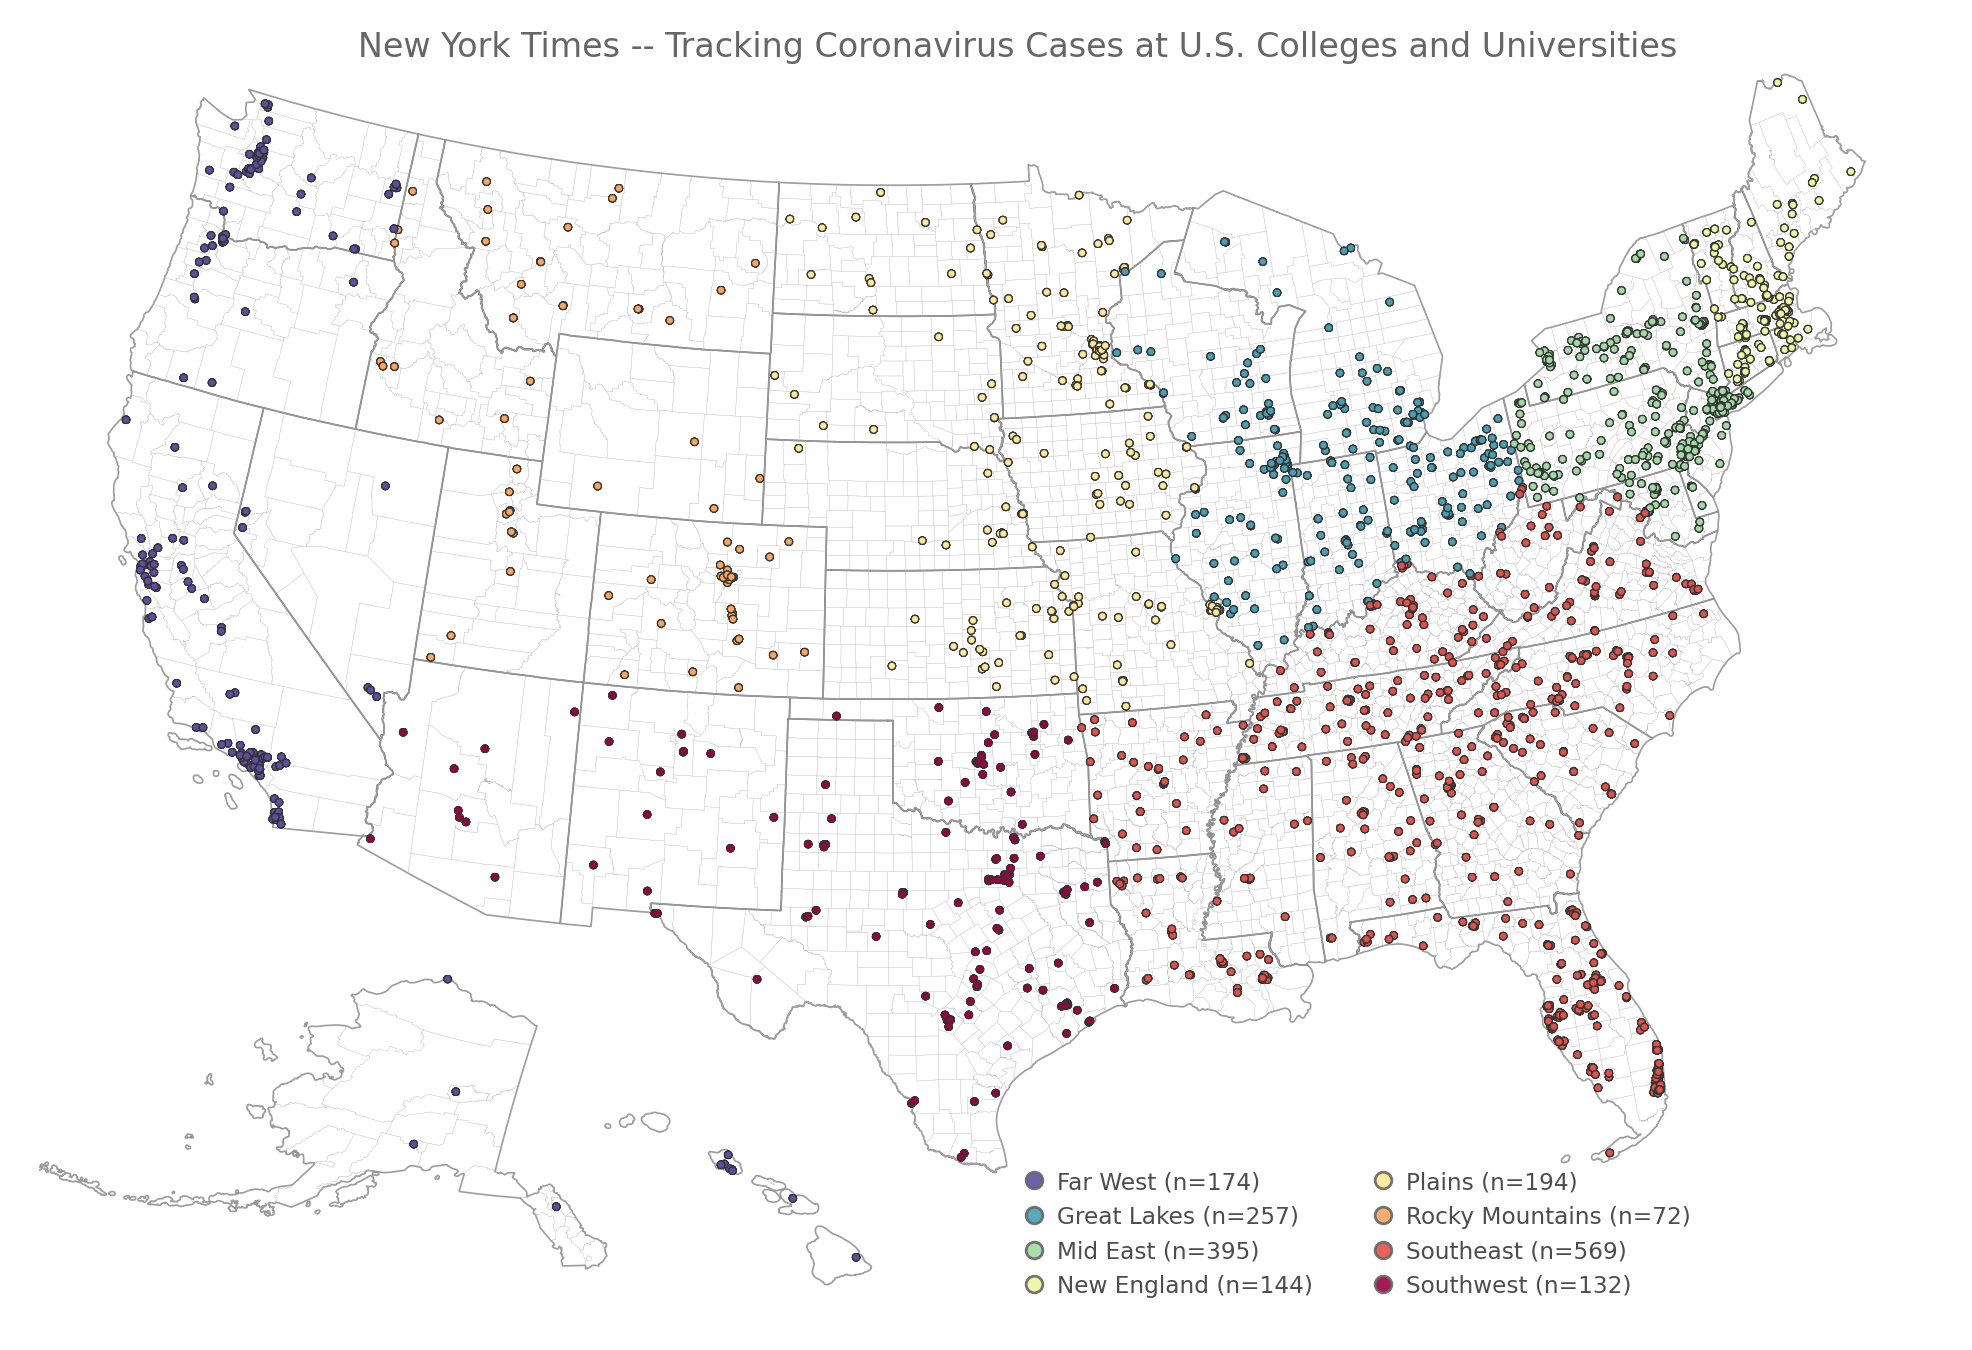

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,8),dpi=200)

gdfs.plot(ax=ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc.plot(ax=ax, lw=0.1, ec='.7', fc='none', alpha=0.8)

al_ax = ax.inset_axes([0.01, -0.09, 0.30, 0.35], transform=ax.transAxes)
hi_ax = ax.inset_axes([0.25, -0.08, 0.20, 0.20], transform=ax.transAxes)

gdfs_AL.plot(ax=al_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc_AL.plot(ax=al_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
al_xmin, al_ymin, al_xmax, al_ymax = gdfs_AL.total_bounds
al_ydiff = al_ymax-al_ymin
al_xdiff = al_xmax-al_xmin
al_ax.set_ylim(al_ymin-al_ydiff*0.02, al_ymax+al_ydiff*0.01)
al_ax.set_xlim(al_xmin+al_xdiff*0.08, al_xmax+al_xdiff*0.02)

gdfs_HI.plot(ax=hi_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc_HI.plot(ax=hi_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
hi_xmin, hi_ymin, hi_xmax, hi_ymax = gdfs_HI.total_bounds
hi_ydiff = hi_ymax-hi_ymin
hi_xdiff = hi_xmax-hi_xmin
hi_ax.set_ylim(hi_ymin-hi_ydiff*0.02, hi_ymax-hi_ydiff*0.75)
hi_ax.set_xlim(hi_xmin+hi_xdiff*0.60, hi_xmax+hi_xdiff*0.02)

ms = 7
nyt_gdf.plot(ax=ax, column='region_label', legend=True, markersize=ms, lw=0.4, ec='.2', alpha=0.9,
             cmap='Spectral_r', vmin=0, vmax=nyt_gdf.region.nunique()-1,
             legend_kwds={'ncol':2, 'fontsize':'small', 'framealpha':0, 'markerscale':0.6,
                          'loc':'lower right', 'bbox_to_anchor':[0.875, -0.075], 'handletextpad':0})
nyt_gdf_HI.plot(ax=hi_ax, column='region_label', markersize=ms, lw=0.4, ec='.2', alpha=0.9,
                cmap='Spectral_r', vmin=0, vmax=nyt_gdf.region.nunique()-1)
nyt_gdf_AL.plot(ax=al_ax, column='region_label', markersize=ms, lw=0.4, ec='.2', alpha=0.9,
                cmap='Spectral_r', vmin=0, vmax=nyt_gdf.region.nunique()-1)

leg = ax.get_legend()
for t in leg.get_texts():
    t.set_color('.3')
for l in leg.get_lines():
    l._legmarker.set_markeredgewidth(1.0)
    l._legmarker.set_markeredgecolor('.4')

ax.set_axis_off()
hi_ax.set_axis_off()
al_ax.set_axis_off()

ax.set_title('New York Times -- Tracking Coronavirus Cases at U.S. Colleges and Universities',
             x=0.175, y=0.95, va='bottom', ha='left', color='.4')

plt.savefig('../figs/pngs/nyt_college_data_map.png', dpi=600, bbox_inches='tight')

plt.show()

In [25]:
nyt_df.to_csv('../data/nyt_data_asof_2021-05-26.csv',index=False)

In [20]:
prev_nyt_data.columns

Index(['date', 'end_date', 'start_date', 'period', 'ipeds_id', 'state',
       'county', 'city', 'college', 'cases', 'new_cases', 'fips'],
      dtype='object')

In [21]:
# https://nces.ed.gov/ipeds/datacenter/default.aspx?gotoReportId=5&fromIpeds=true

In [22]:
usr_agent = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/61.0.3163.100 Safari/537.36'}

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *

# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

ipeds_data = client.open("CampusCOVID-IPEDS_data").worksheet('ipeds')
ipeds_df = pd.DataFrame(ipeds_data.get_all_records(default_blank=np.nan))
ipeds_df['ipeds_id'] = ipeds_df['ipeds_id'].astype(str)

ipeds_addon = client.open("CampusCOVID-IPEDS_data").worksheet('additional')
ipeds_extra_df = pd.DataFrame(ipeds_addon.get_all_records(default_blank=np.nan))
ipeds_extra_df['ipeds_id'] = ipeds_extra_df['ipeds_id'].astype(str)

ModuleNotFoundError: No module named 'gspread'

In [ ]:
ipeds_df['campus_population_fulltime'] = ipeds_df['enrollment_fulltime'] + ipeds_df['employment_fulltime']
ipeds_df['campus_population_total'] = ipeds_df['enrollment_total'] + ipeds_df['employment_fulltime']

In [ ]:
nyt_out = nyt_df.merge(ipeds_df[['ipeds_id','enrollment_fulltime','employment_fulltime','campus_population_fulltime']],
                       how='left', on='ipeds_id')
nyt_out = nyt_out.loc[~nyt_out['enrollment_fulltime'].isna()].copy().reset_index().iloc[:,1:]

In [ ]:
ipeds_df.columns

In [ ]:
nyt_out.loc[nyt_out['cases']<0,'cases'] = 0
nyt_out.loc[nyt_out['new_cases']<0,'new_cases'] = 0
nyt_out['cases_per1000_pop_fulltime'] = nyt_out['cases'] / nyt_out['campus_population_fulltime'] * 1000
nyt_out['new_cases_per1000_pop_fulltime'] = nyt_out['new_cases'] / nyt_out['campus_population_fulltime'] * 1000

In [ ]:
nyt_out = nyt_out.merge(ipeds_df[['ipeds_id',
                       'percent_enrollment_aian',
                       'percent_enrollment_black',
                       'percent_enrollment_latino',
                       'percent_enrollment_white',
                       'percent_enrollment_multiracial',
                       'percent_enrollment_raceunknown',
                       'percent_enrollment_asianbroad']], how='left', on='ipeds_id')

In [ ]:
fig, ax = plt.subplots(1,6,figsize=(16,3),dpi=200,sharex=True,sharey=True)

for pi,p in enumerate(nyt_out['period'].unique()):
    dfp = nyt_out.loc[nyt_out['period']==p].copy()
#     ax[p].scatter(dfp['percent_enrollment_black'], dfp['new_cases_per1000_pop_fulltime'],s=10,lw=0)
    ax[p].scatter(dfp['percent_enrollment_white'], dfp['new_cases_per1000_pop_fulltime'],s=10,lw=0)
    ax[p].set_yscale('log')
#     ax[p].set_xscale('log')
    ax[p].set_ylim(1e-2,1e3)
#     ax[p].set_xlim(1e0,1e2)

plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
covariate_cols = ['period',#'region',
                  'campus_population_fulltime',
                  'percent_enrollment_aian',
                  'percent_enrollment_black',
                  'percent_enrollment_latino',
                  'percent_enrollment_white',
                  'percent_enrollment_multiracial',
                  'percent_enrollment_raceunknown',
                  'percent_enrollment_asianbroad']

covariate_str = " + ".join(covariate_cols)

In [ ]:
mod = smf.gls(formula='cases_per1000_pop_fulltime ~ '+covariate_str, data=nyt_out)
res = mod.fit()

In [ ]:
print(res.summary())

In [ ]:
# fix_enrollment_df = nyt_out.loc[(nyt_out['enrollment_fulltime'].isna())][['college','ipeds_id']].drop_duplicates()
# fix_enrollment_df['enrollment_fulltime'] = np.nan
# for test_col in fix_enrollment_df['college'].values:
#     search_term = test_col + " number of students"
#     escaped_search_term = search_term.replace(' ', '+')
#     google_url = 'https://www.google.com/search?q={}&num={}&hl={}'.format(escaped_search_term, 11, 'en')
#     response = get(google_url, headers=usr_agent)
#     raw_html = response.text
#     soup = BeautifulSoup(raw_html, 'html.parser')

#     try:
#         outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d'})[0].text.replace(',',''))
#         print(search_term,outx)
#     except:
#         try:
#             outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d AZCkJd'})[0].text.replace(',',''))
#             print(search_term,outx)
#         except:
#             outx = np.nan
#             print('\tdid not work for',search_term)
            
#     fix_enrollment_df.loc[fix_enrollment_df['college']==test_col, 'enrollment_fulltime'] = outx
    
# for test_col in fix_enrollment_df.loc[fix_enrollment_df['enrollment_fulltime'].isna()]['college'].values:
#     search_term = test_col + " how many students"
#     escaped_search_term = search_term.replace(' ', '+')
#     google_url = 'https://www.google.com/search?q={}&num={}&hl={}'.format(escaped_search_term, 11, 'en')
#     response = get(google_url, headers=usr_agent)
#     raw_html = response.text
#     soup = BeautifulSoup(raw_html, 'html.parser')

#     try:
#         outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d'})[0].text.replace(',',''))
#         print(search_term,outx)
#     except:
#         try:
#             outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d AZCkJd'})[0].text.replace(',',''))
#             print(search_term,outx)
#         except:
#             outx = np.nan
#             print('\tdid not work for',search_term)
            
#     fix_enrollment_df.loc[fix_enrollment_df['college']==test_col, 'enrollment_fulltime'] = outx    

# for test_col in fix_enrollment_df.loc[fix_enrollment_df['enrollment_fulltime'].isna()]['college'].values:
#     search_term = test_col + " enrollment"
#     escaped_search_term = search_term.replace(' ', '+')
#     google_url = 'https://www.google.com/search?q={}&num={}&hl={}'.format(escaped_search_term, 11, 'en')
#     response = get(google_url, headers=usr_agent)
#     raw_html = response.text
#     soup = BeautifulSoup(raw_html, 'html.parser')

#     try:
#         outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d'})[0].text.replace(',',''))
#         print(search_term,outx)
#     except:
#         try:
#             outx = float(soup.find_all('div', attrs={'class':'Z0LcW XcVN5d AZCkJd'})[0].text.replace(',',''))
#             print(search_term,outx)
#         except:
#             outx = np.nan
#             print('\tdid not work for',search_term)
            
#     fix_enrollment_df.loc[fix_enrollment_df['college']==test_col, 'enrollment_fulltime'] = outx    